# Centrality

In some applications we might want to know which nodes of a network are the most important. For instance, we might want to find influential members of a social network, or nodes that are critical for efficient connections within the network. These traits go under the general name of **centrality**. 

An easy candidate for measuring the centrality of a node is its degree. Usually this is normalized by the number of nodes in the graph and called **degree centrality**. While it can yield useful infortmation in some networks, it is not always a reliable measuring stick. For example, consider the following Watts–Strogatz graph:

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

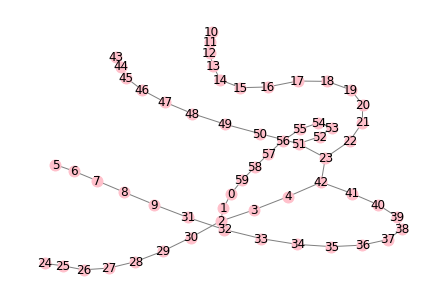

In [2]:
G = nx.watts_strogatz_graph(60,2,.1,seed=6)
pos = nx.spring_layout(G,seed=1)
style = dict(pos=pos,edge_color="gray",node_color="pink",with_labels=True)
nx.draw(G,**style,node_size=120)

There is little variation in the degrees of the nodes. In fact, there are only 3 unique values of the degree centrality:

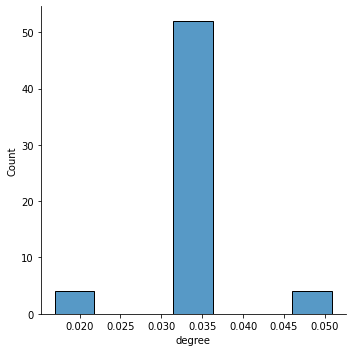

In [3]:
centrality = pd.DataFrame({"degree":nx.degree_centrality(G)},index=G.nodes)
sns.displot(data=centrality,x="degree");

From the drawing of the graph, however, it's clear that (for instance) nodes 3 and 6 do not have comparable roles, despite the fact that both have degree equal to 2.

## Betweenness centrality

A different way to measure centrality is to use shortest paths between nodes. Let $\sigma(i,j)$ denote the number of shortest paths between nodes $i$ and $j$. This means that we count the number of unique ways to get between these nodes using the minimum possible number of edges. Let $\sigma(i,j|k)$ be the number of such paths that pass through node $k$. Then, for a graph on $n$ nodes, the **betweenness centrality** of node $k$ is

$$
c_B(k) = \frac{1}{\binom{n-1}{2}}\, \displaystyle\sum_{\substack{\text{all pairs }i,j\\i\neq k,\,j\neq k}} \frac{\sigma(i,j|k)}{\sigma(i,j)}.
$$

Each term in the sum is less than or equal to 1, and the number of terms in the sum is $\binom{n-1}{2}$, so $0\le c_B \le 1$ for any node. The definition requires an expensive computation if the number of nodes is more than a few hundred, so the $\sigma$ values are often estimated by sampling.

::::{prf:example}
:label: example-centrality-between
Find the betweenness centrality of the following *barbell graph*:

```{image} barbell.svg
:alt: barbell graph
:width: 360px
:align: center
```

:::{dropdown} Solution
Let's begin with node 3, in the middle. Any path, and therefore any shortest path, between nodes 0, 1, or 2 and nodes 4, 5, or 6 must pass through node 3, so these pairings each contribute 1 to the sum. The shortest paths for pairs of nodes within the end triangles clearly do not pass through node 3. Hence 

$$
c_B(3) = \frac{1}{15} \cdot (3\cdot 3) = \frac{3}{5}.
$$

Next, consider node 2. The shortest paths through this node are the ones that pair nodes 0 or 1 with nodes 3, 4, 5, or 6, so

$$
c_B(2) = \frac{1}{15} \cdot (2\cdot 4) = \frac{8}{15}.
$$

By symmetry, we get the same value for node 4.

All the other nodes play no role in any shortest paths. For instance, any path passing through node 0 can be replaced with a shorter one that follows the edge between nodes 1 and 2. Hence $c_B$ is zero on these nodes.
:::
::::


The `betweenness_centrality` function returns a dictionary with nodes as keys and $c_B$ as values.

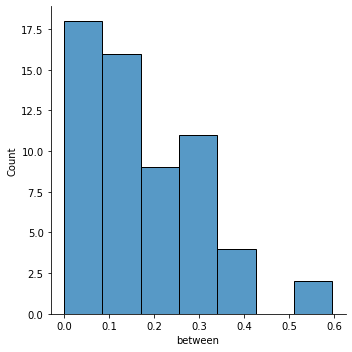

In [4]:
centrality["between"] = pd.Series(nx.betweenness_centrality(G))
sns.displot(data=centrality,x="between");

The distribution above shows that few nodes have a relatively high betweenness score in our graph.

## Eigenvector centrality

A different way of distinguishing nodes of high degree is to suppose that not all links are equally valuable. By analogy with ranking sports teams, where wins over good teams should count for more than wins over bad teams, we should assign more importance to nodes that link to other important nodes. 

We can try to turn this idea into an algorithm as follows. Suppose we initially assign uniform centrality scores $x_1,\ldots,x_n$ to all of the nodes. Now we can update the scores by looking at the current scores for all the neighbors. Specifically, the new scores are

$$
x_i^+ = \sum_{j\text{ adjacent to }i} x_j = \sum_{j=1}^n A_{ij} x_j,\quad i=1,\ldots,n,
$$

where $A_{ij}$ are entries of the adjacency matrix. Once we have updated the scores, we can repeat the process to update them again, and so on. If the scores were to converge, in the sense that $x_i^+$ approaches $x_i$, then we would have a solution of the equation

$$
x_i \stackrel{?}{=} \sum_{j=1}^n A_{ij} x_j, \quad i=1,\ldots,n.
$$

In fact, since the sums are all inner products across rows of $\bfA$, this is simply

$$
\bfx \stackrel{?}{=} \bfA \bfx.
$$

Except for $\bfx$ equal to the zero vector, this equation does not have a solution in general. However, if we relax it just a bit, we get somewhere important. Instead of equality, let's look for *proportionality*, i.e.,

$$
\lambda \bfx = \bfA \bfx
$$

for a number $\lambda$. This is an **eigenvalue equation**, one of the fundamental problems in linear algebra. 

::::{prf:example}
:label: example-centrality-eigenvector
Consider the complete graph $K_3$, which is just a triangle. Its adjacency matrix is

$$
\bfA = \begin{bmatrix} 
0 & 1 & 1 \\ 1 & 0 & 1 \\ 1 & 1 & 0
\end{bmatrix}.
$$

We should hope that all three vertices are ranked equally. In fact, if we define $\bfx=\tfrac{1}{3}[1,1,1]$, then 

$$
\bfA \bfx = \bigl[\tfrac{2}{3},\tfrac{2}{3},\tfrac{2}{3} \bigr] = 2 \bfx,
$$

so that $\lambda=2$ is an eigenvalue to go with eigenvector $\bfx$. Note that any (nonzero) multiple of $\bfx$ would work just as well:

$$
\bfA (c \bfx) =  \bigl[\tfrac{2}{3}c,\tfrac{2}{3}c,\tfrac{2}{3}c \bigr] = 2 (c\bfx),
$$

so that $c\bfx$ is also an eigenvector. All that the eigenvector gives us, then, is *relative* centrality of the nodes, though it would be natural to normalize it so that its elements sum to 1.
::::


Every $n\times n$ matrix has at least one nonzero solution to the eigenvalue equation, although complex numbers might be involved. For an adjacency matrix, the *Perron–Frobenius theorem* guarantees a real solution for some $\lambda > 0$ and for which the $x_i$ all have the same sign. That last property allows us to interpret the $x_i$ as relative importance or centrality of the nodes. This is called **eigenvector centrality**.

NetworkX has two functions for computing eigenvector centrality. Here we use the one that calls on numpy to solve the eigenvalue problem. As with betweenness centrality, the return value is a dictionary with nodes as the keys.

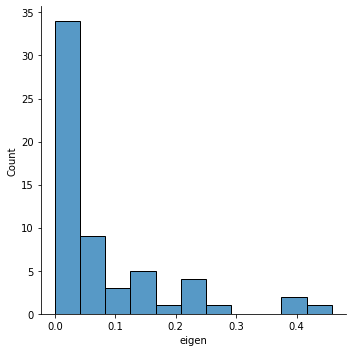

In [5]:
centrality["eigen"] = pd.Series(nx.eigenvector_centrality_numpy(G))
sns.displot(data=centrality,x="eigen");

You can see above that eigenvector centrality distinguishes a small number of nodes in our example.

## Comparison

We can verify using correlation coefficients that while the three centrality measures are related, they are far from redundant:

In [6]:
centrality.corr()

,degree,between,eigen
degree,1.000000,0.630732,0.601884
between,0.630732,1.000000,0.736732
eigen,0.601884,0.736732,1.000000


Here is how betweenness ranks the centrality of the nodes:

In [7]:
centrality.sort_values(by="between",ascending=False).head(8)

,degree,between,eigen
42,0.050847,0.595850,0.405831
23,0.050847,0.576856,0.458056
41,0.033898,0.385739,0.232910
40,0.033898,0.368206,0.133669
51,0.050847,0.363822,0.392303
39,0.033898,0.349503,0.076714
38,0.033898,0.329632,0.044027
22,0.033898,0.329632,0.262883


As you can see, the top two are quite clear, and a drawing of the graph supports the case that they are central:

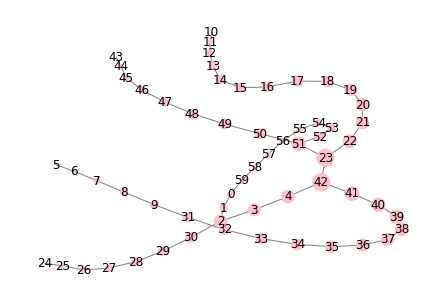

In [8]:
nx.draw(G,node_size=500*centrality["between"],**style)

A weakness, though, is that there is are many secondary nodes whose values taper off only slowly as we enter the remote branches.

Here is a ranking according to eigenvector centrality:

In [9]:
centrality.sort_values(by="eigen",ascending=False).head(8)

,degree,between,eigen
23,0.050847,0.576856,0.458056
42,0.050847,0.595850,0.405831
51,0.050847,0.363822,0.392303
22,0.033898,0.329632,0.262883
4,0.033898,0.311806,0.249077
41,0.033898,0.385739,0.232910
52,0.033898,0.134717,0.225527
50,0.033898,0.212741,0.225125


This ranking has a clear top choice, followed by two that are nearly identical.

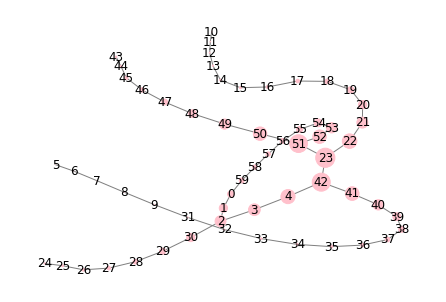

In [10]:
nx.draw(G,node_size=800*centrality["eigen"],**style)

Eigenvector centrality identifies a more compact and distinct center. Of course, these observations are all made for a single network, so be careful not to over-generalize!

## Power-law example

Let's take a look at centrality measures for a power-law graph of the same size. By construction, a BA graph has a hub-and-spoke structure.

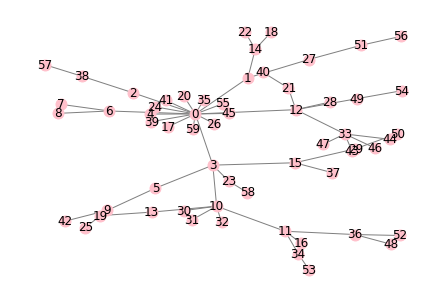

In [11]:
G = nx.barabasi_albert_graph(60,1,seed=2)
style["pos"] = nx.spring_layout(G,seed=3)
nx.draw(G,**style,node_size=120)

Degree centrality certainly notices the gregarious node 0:

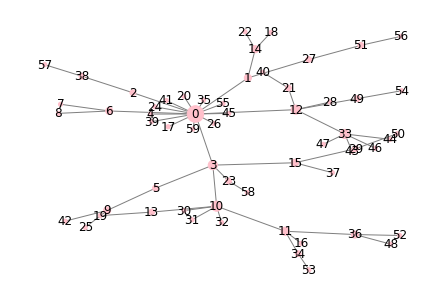

In [12]:
centrality = pd.DataFrame({"degree":nx.degree_centrality(G)},index=G.nodes)
nx.draw(G,node_size=1000*centrality["degree"],**style)

However, as you see above, the secondary hubs do not stand out much. Betweenness centrality highlights them quite nicely here:

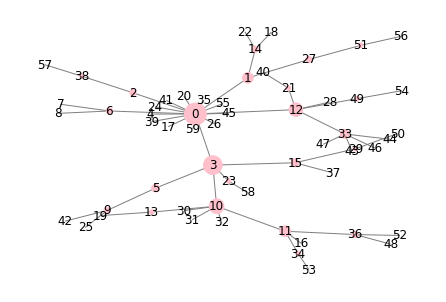

In [13]:
centrality["between"] = pd.Series(nx.betweenness_centrality(G))
nx.draw(G,node_size=600*centrality["between"],**style)

On the other hand, eigenvector centrality puts a lot of emphasis on the friends of node 0, even the ones that are dead ends, at the expense of the secondary hubs:

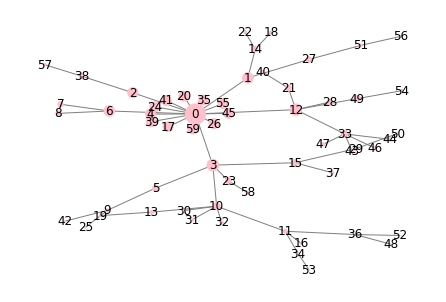

In [14]:
centrality["eigen"] = pd.Series(nx.eigenvector_centrality_numpy(G))
nx.draw(G,node_size=600*centrality["eigen"],**style)

This undesirable aspect of eigenvector centrality can be fixed through an extra normalization by the node degree, so that the hub node divides its "attention" into smaller parts. Such thinking leads to the *PageRank* algorithm, which is what put Google on the map for web searches.

## Friendship paradox

A surprising fact about social networks is that on average, your friends have more friends than you do, a fact that is called the **friendship paradox**. Let $\mathbf{d}$ be an $n$-vector whose components are the degrees of the nodes in the network. On average, the number of "friends" (i.e., adjacent nodes) is the average degree, which is equal to

$$
\frac{\onenorm{\mathbf{d}}}{n}. 
$$

Now imagine that we create a list as follows: for each node $i$, add to the list the number of friends of each of $i$'s friends. The mean value of this list is the average number of "friends of friends." 

For example, consider the following graph:

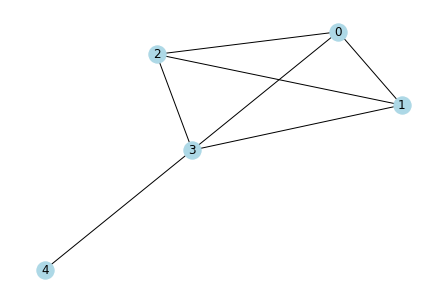

In [15]:
L = nx.lollipop_graph(4,1)
nx.draw(L,with_labels=True,node_color="lightblue")

The average degree is $(3+3+3+4+1)/5=14/5$. Here are the entries in our friends-of-friends list contributed by each node:

* Node 0: 3 (from node 1), 3 (from node 2), 4 (from node 3)
* Node 1: 3 (from node 0), 3 (from node 2), 4 (from node 3)
* Node 2: 3 (from node 0), 3 (from node 1), 4 (from node 3)
* Node 3: 3 (from node 0), 3 (from node 1), 3 (from node 2), 1 (from node 4)
* Node 4: 4 (from node 3)

The average value of this list, i.e., the average number of friends' friends, is $44/14=3.143$, which is indeed larger than the average degree.

There is an easy way to calculate this value in general. Node $i$ contributes $d_i$ terms to the list, so the total number of terms is $\onenorm{\mathbf{d}}$. We observe that node $i$ appears $d_i$ times in the list, each time contributing the value $d_i$, so the sum of the entire list must be 

$$
\sum_{i=1}^n d_i^2 = \twonorm{\mathbf{d}}^2 = \mathbf{d}^T \mathbf{d}. 
$$

Hence the mathematical statement of the friendship paradox is

::::{math}
:label: eq-centrality-friendship-paradox
\frac{\onenorm{\mathbf{d}}}{n} \le \frac{\mathbf{d}^T \mathbf{d}}{\onenorm{\mathbf{d}}}.
::::

You are asked to prove this inequality in the exercises. Here is a verification for the BA graph above:

In [16]:
n = G.number_of_nodes()
d = pd.Series(dict(G.degree),index=G.nodes)
dbar = d.mean()
dbar_friends = np.dot(d,d)/d.sum()

print(dbar,"is less than",dbar_friends)

1.9666666666666666 is less than 4.389830508474576


The friendship paradox generalizes to eigenvector centrality: the average centrality of all nodes is less than the average of the centrality of all nodes' friends. The mathematical statement is 

::::{math}
:label: eq-centrality-eigen-paradox
\frac{\onenorm{\mathbf{x}}}{n} \le \frac{\mathbf{x}^T \mathbf{d}}{\onenorm{\mathbf{d}}},
::::

where $\bfx$ is the eigenvector defining centrality of the nodes.

In [17]:
x = centrality["eigen"]
xbar = x.mean()
xbar_friends = np.dot(x,d)/sum(d)
print(xbar,"is less than",xbar_friends)

0.07583936265862014 is less than 0.15936510918420188


In fact, the friendship paradox inequality for any vector $\bfx$ is equivalent to $\bfx$ having nonnegative correlation with the degree vector.